# Mask R-CNN - Inspect Ballon Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.balloon import balloon

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
BALLON_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_balloon.h5")  # TODO: update this path

Using TensorFlow backend.


In [2]:
ROOT_DIR

'C:\\Users\\Angel\\mask\\Mask_RCNN'

In [3]:
MODEL_DIR

'C:\\Users\\Angel\\mask\\Mask_RCNN\\logs'

In [4]:
BALLON_WEIGHTS_PATH

'C:\\Users\\Angel\\mask\\Mask_RCNN\\mask_rcnn_balloon.h5'

## Configurations

In [5]:
config = balloon.BalloonConfig()
BALLOON_DIR = os.path.join(ROOT_DIR, "datasets/balloon")

In [6]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [7]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [8]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [9]:
# Load validation dataset
dataset = balloon.BalloonDataset()
dataset.load_balloon(BALLOON_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 13
Classes: ['BG', 'balloon']


## Load Model

In [10]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [11]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
weights_path = BALLON_WEIGHTS_PATH

# Or, load the last model you trained
#weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  C:\Users\Angel\mask\Mask_RCNN\mask_rcnn_balloon.h5


## Run Detection

image ID: balloon.410488422_5f8991f26e_b.jpg (12) C:\Users\Angel\mask\Mask_RCNN\datasets/balloon\val\410488422_5f8991f26e_b.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (3,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (3, 4)                min:  129.00000  max:  914.00000  int32
gt_mask                  shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  bool


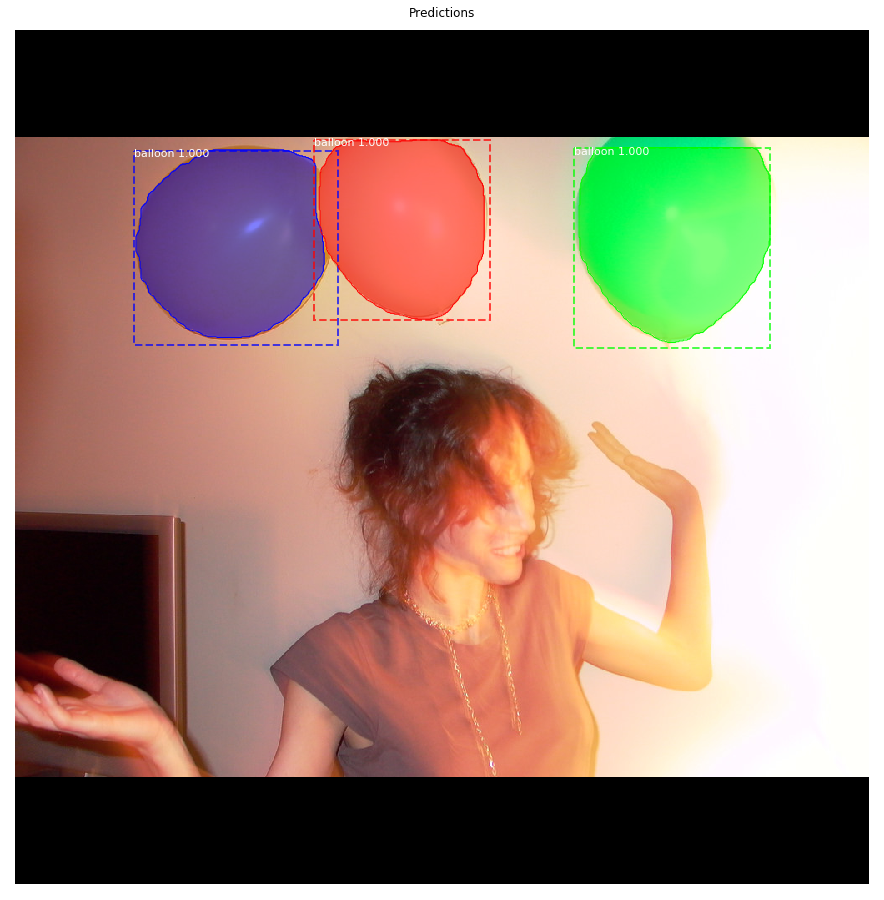

In [12]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

## Color Splash

This is for illustration. You can call `balloon.py` with the `splash` option to get better images without the black padding.

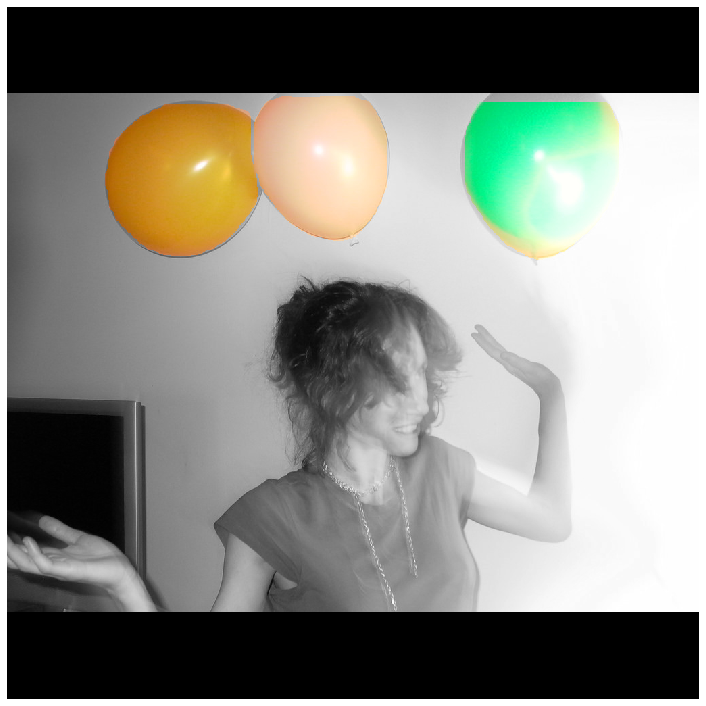

In [13]:
splash = balloon.color_splash(image, r['masks'])
display_images([splash], cols=1)

# Prueba con polen:

Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  190.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   85.33437  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


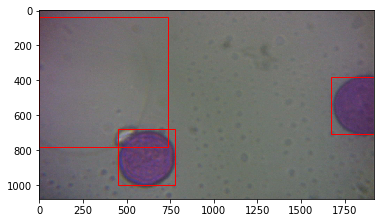

In [41]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib.patches import Rectangle

# draw an image with detected objects
def draw_image_with_boxes(filename, boxes_list):
     # load the image
     data = plt.imread(filename)
     # plot the image
     plt.imshow(data)
     # get the context for drawing boxes
     ax = plt.gca()
     # plot each box
     for box in boxes_list:
          # get coordinates
          y1, x1, y2, x2 = box
          # calculate width and height of the box
          width, height = x2 - x1, y2 - y1
          # create the shape
          rect = Rectangle((x1, y1), width, height, fill=False, color='red')
          # draw the box
          ax.add_patch(rect)
     # show the plot
     plt.show()

# load photograph
img = load_img('Muestra1.jpg')
img = img_to_array(img)
# make prediction
results = model.detect([img], verbose=1)
boxes = results[0]['rois'] #We can draw each box detected in the image
draw_image_with_boxes('Muestra1.jpg', boxes)

In [42]:
boxes

array([[ 381, 1675,  708, 1920],
       [ 679,  449, 1002,  778],
       [  37,    0,  785,  738]])

In [43]:
boxes=boxes[:2]

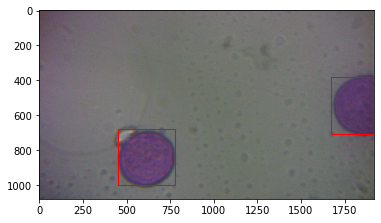

In [44]:
draw_image_with_boxes('Muestra1.jpg', boxes)

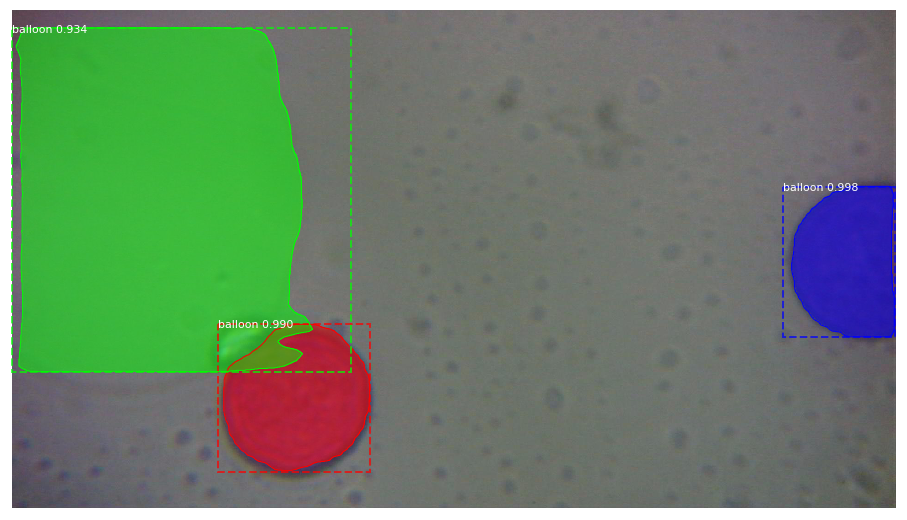

In [45]:
r = results[0]
visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'])

In [53]:
# Get predictions of mask head
mrcnn = model.run_graph([img], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
3 detections: ['balloon' 'balloon' 'balloon']


In [54]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], img.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], img.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (3, 28, 28)           min:    0.00000  max:    1.00000  float32
det_masks                shape: (3, 1080, 1920)       min:    0.00000  max:    1.00000  bool


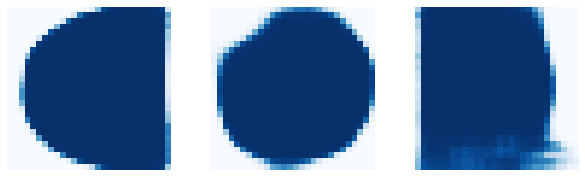

In [55]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

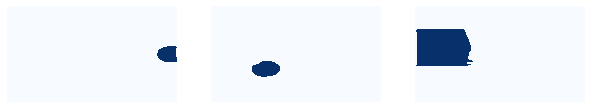

In [56]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

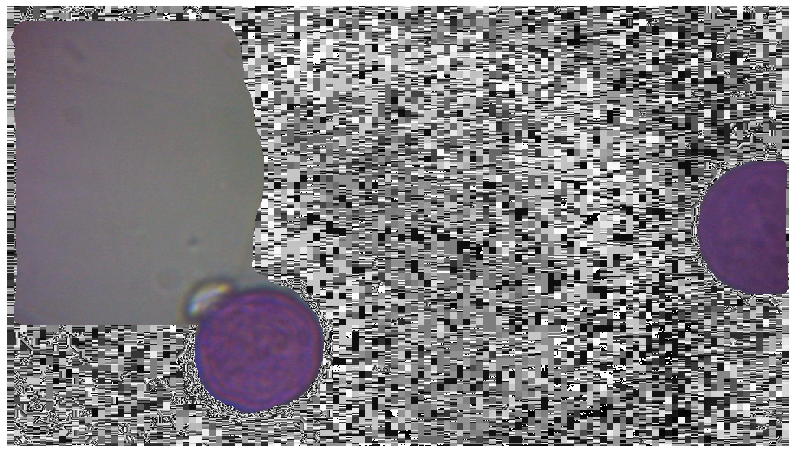

In [57]:
splash = balloon.color_splash(img, r['masks'])
display_images([splash], cols=1)

In [48]:
mask=r['masks']
len(mask)

1080

In [49]:
r

{'rois': array([[ 381, 1675,  708, 1920],
        [ 679,  449, 1002,  778],
        [  37,    0,  785,  738]]),
 'class_ids': array([1, 1, 1]),
 'scores': array([0.99751115, 0.98967254, 0.93354493], dtype=float32),
 'masks': array([[[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [False, False, False],
         [False, False, False]],
 
        [[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [False, False, False],
         [False, False, False]],
 
        [[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [False, False, False],
         [False, False, False]],
 
        ...,
 
        [[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, 

In [39]:
r = results[0]
r['rois']=boxes
r['class_ids']=r['class_ids'][:2]
r['scores']=r['scores'][:2]

visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'])

AssertionError: 

In [38]:
r

{'rois': array([[ 381, 1675,  708, 1920],
        [ 679,  449, 1002,  778]]),
 'class_ids': array([1, 1]),
 'scores': array([0.99751115, 0.98967254], dtype=float32),
 'masks': array([[[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [False, False, False],
         [False, False, False]],
 
        [[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [False, False, False],
         [False, False, False]]])}

## Visualize Activations

In [58]:
# Get activations of a few sample layers
activations = model.run_graph([img], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max:   85.33437  float32
res2c_out                shape: (1, 256, 256, 256)    min:    0.00000  max:   19.71355  float32
res3c_out                shape: (1, 128, 128, 512)    min:    0.00000  max:   28.80074  float32
res4w_out                shape: (1, 64, 64, 1024)     min:    0.00000  max:   57.90160  float32
rpn_bbox                 shape: (1, 261888, 4)        min:   -6.21736  max:  113.88879  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


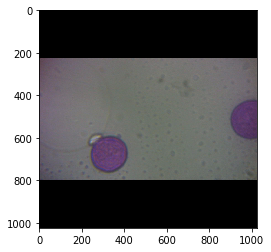

In [59]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

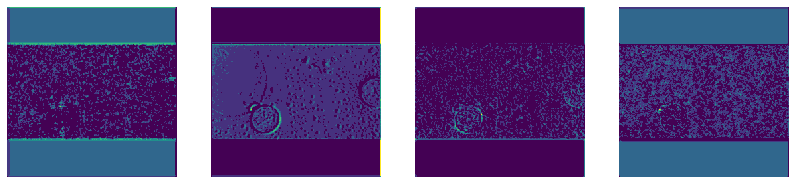

In [60]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)